In [9]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

C:\Users\Ferna\AppData\Local\Temp\ipykernel_29976\2527633043.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval = interval, period = PERIOD )
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,12_ema,27_ema,MACD,Signal,MACD_hist,MACD_Strategy,BB_SMA,STDV,Upper_Band,Lower_Band,BB_Strategy,Full_Strategy,Strategy,Asset_Returns,Strategy_Returns
19,412.505005,412.609985,411.429993,411.633209,6085080,412.775239,413.111555,0.336316,0.173853,0.162463,1.0,413.348993,1.320288,415.989568,410.708417,NaN,NaN,0,NaN,NaN
20,413.450012,413.709991,412.403595,412.440002,6350192,412.882256,413.142193,0.259937,0.191230,0.068707,1.0,413.437993,1.259759,415.957510,410.918475,0.0,1.0,0,0.002291,0.000000
21,416.709991,417.619995,415.179993,415.179993,12608598,413.486452,413.459105,-0.027347,0.147190,-0.174536,1.0,413.650493,1.432686,416.515865,410.785120,0.0,1.0,0,0.010194,0.000000
22,415.690002,417.339996,415.540009,416.739990,6784718,413.832889,413.653877,-0.179012,0.081562,-0.260574,-1.0,413.774498,1.498370,416.771238,410.777758,-1.0,-2.0,-1,0.007721,0.002448
23,412.769989,415.959991,412.470001,415.679993,9138013,413.666344,413.577914,-0.088430,0.047402,-0.135832,-1.0,413.682997,1.501180,416.685356,410.680638,0.0,-1.0,0,0.000642,0.002448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5078,617.900024,619.219971,617.400024,617.900024,21415473,615.681794,612.652152,-3.029642,-3.075539,0.045897,1.0,614.321765,2.516275,619.354315,609.289215,0.0,1.0,0,0.497921,-0.075035
5079,617.119995,618.065002,616.255005,616.359985,12323435,615.903056,612.971284,-2.931772,-3.046786,0.115013,1.0,614.673264,2.381426,619.436116,609.910411,0.0,1.0,0,0.496030,-0.075035
5080,617.280029,617.609985,615.520020,617.099976,11591882,616.114898,613.279051,-2.835847,-3.004598,0.168751,1.0,614.993265,2.272386,619.538037,610.448493,0.0,1.0,0,0.496418,-0.075035
5081,617.320007,618.099976,616.080017,617.270020,32787182,616.300299,613.567691,-2.732609,-2.950200,0.217592,1.0,615.299765,2.142073,619.583912,611.015618,0.0,1.0,0,0.496515,-0.075035


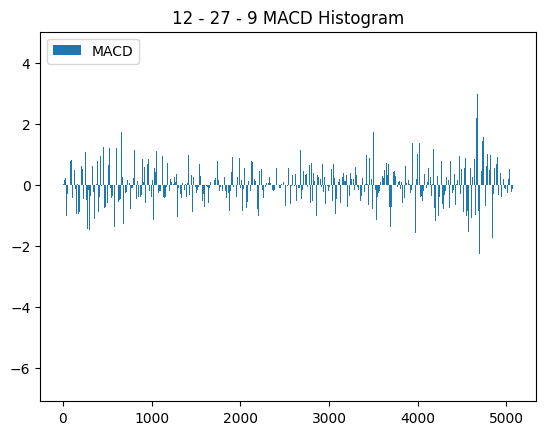

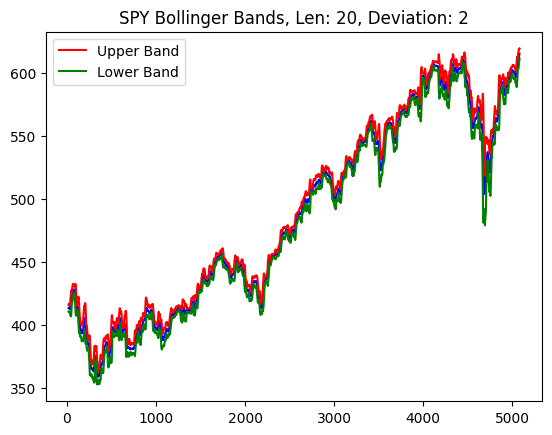

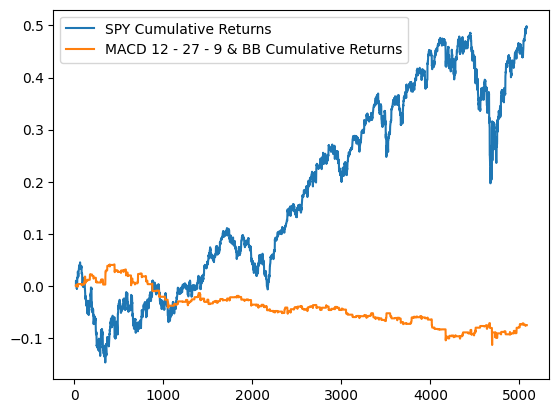

In [10]:
TICKER = 'SPY'
INTERVAL = '1h'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

# MACD parameters
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9

# BB parameters
BB_LEN = 20
DEV = 2

# subsection of data we are interested
LOOKBACK = 10000

def get_data(ticker = TICKER, lookback = LOOKBACK, interval = INTERVAL):

    # get data at interval
    df = yf.download(ticker, interval = interval, period = PERIOD ) 
    df.columns = df.columns.get_level_values(0)

    df = df.reset_index(drop = True) # Changes dates to numbers so we don't have weird weekend gaps when plotting

    return df.iloc[-lookback:,:] #Take a piece of the last "LOOKBACK" rows

def add_MACD(df, fast = MACD_FAST, slow = MACD_SLOW, span = MACD_SPAN):
    df[f'{fast}_ema'] = df['Close'].ewm(span = fast).mean()
    df[f'{slow}_ema'] = df['Close'].ewm(span = slow).mean()

    df['MACD'] = df[f'{slow}_ema'] - df[f'{fast}_ema']

    df['Signal'] = df['MACD'].ewm(span = span).mean()

    #Part 2
    df['MACD_hist'] = df['MACD'] - df['Signal']

    #Plot
    plt.bar(x = df.index, height=df['MACD_hist']) 

    #for the bar graph make sure to define the indexes. The x index is a time index that is set by default on yfinance 
    plt.legend(['MACD', 'Signal'])
    plt.title(f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Histogram')

    return df

def add_MACD_strategy(df):
    df['MACD_Strategy'] = 0
    df['MACD_Strategy'] = np.where(df['MACD_hist'] > 0, 1, -1)
    df['MACD_Strategy'] = df['MACD_Strategy'].shift(1)

    return df

def add_bollinger_bands(df, ticker = TICKER, dev = DEV, bb_len = BB_LEN):

    # can use ema
    df['BB_SMA'] = df['Close'].rolling(bb_len).mean()

    # get the standard deviation of the close prices for the period
    df['STDV'] = df['Close'].rolling(bb_len).std()

    df['Upper_Band'] = df['BB_SMA'] + (dev * df['STDV'])
    df['Lower_Band'] = df['BB_SMA'] - (dev * df['STDV'])

    df = df.dropna()

    plt.figure()
    plt.plot(df['BB_SMA'], color = 'blue')
    plt.plot(df['Upper_Band'], color = 'red', label='Upper Band')
    plt.plot(df['Lower_Band'], color = 'green', label='Lower Band')
    plt.title(f'{ticker} Bollinger Bands, Len: {bb_len}, Deviation: {dev}')
    plt.legend()

    return df

def add_bb_strategy(df):

    df['BB_Strategy'] = 0
    df['BB_Strategy'] = np.where(df['Close'] > df['Upper_Band'], -1, np.where(df['Close'] < df['Lower_Band'], 1, 0))
    df['BB_Strategy'] = df['BB_Strategy'].shift(1)
    
    return df

def add_full_strategy(df):
    df['Full_Strategy'] = df['MACD_Strategy'] + df['BB_Strategy']

    # adjust values for simplicity
    df['Strategy'] = np.where(df['Full_Strategy'] == 2, 1, np.where(df['Full_Strategy'] == -2, -1, 0))

    return df

def test_strategy(df):
    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() - 1

    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])

    plt.legend([f'{TICKER} Cumulative Returns', f'MACD {MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} & BB Cumulative Returns'])

    return df

def main():
    df = get_data()
    df = add_MACD(df)
    df = add_MACD_strategy(df)
    df = add_bollinger_bands(df)
    df = add_bb_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)
    
    return df

df = main()
df